# Reconstructing the South Pacific Nuclear Free Zone

[The Treaty of Rarotonga](https://treaties.unoda.org/t/rarotonga) contains this description of the application zone (Annex 1):

> The area bounded by a line-
>
> 1. commencing at the point of intersection of the Equator by the maritime boundary between Indonesia and Papua New Guinea;
> 2. running thence northerly along that maritime boundary to its intersection by the outer limit of the Exclusive Economic Zone of Papua New Guinea;
> 3. thence generally north-easterly, easterly and south-easterly along that outer limit to its intersection by the Equator;
> 4. thence east along the Equator to its intersection by the meridian of Longitude 163 degrees East;
> 5. thence north along that meridian to its intersection by the parallel of Latitude 3 degrees North;
> 6. thence east along that parallel to its intersection by the meridian of Longitude 171 degrees East;
> 7. thence north along that meridian to its intersection by the parallel of Latitude 4 degrees North;
> 8. thence east along that parallel to its intersection by the meridian of Longitude 180 degrees East;
> 9. thence south along that meridian to its intersection by the Equator;
> 10. thence east along the Equator to its intersection by the meridian of Longitude 165 degrees West;
> 11. thence north along that meridian to its intersection by the parallel of Latitude 5 degrees 30 minutes North;
> 12. thence east along that parallel to its intersection by the meridian of Longitude 154 degrees West;
> 13. thence south along that meridian to its intersection by the Equator;
> 14. thence east along the Equator to its intersection by the meridian of Longitude 115 degrees West;
> 15. thence south along that meridian to its intersection by the parallel of Latitude 60 degrees South;
> 16. thence west along that parallel to its intersection by the meridian of Longitude 115 degrees East;
> 17. thence north along the meridian to its southernmost intersection by the outer limit of the territorial sea of Australia;
> 18. thence generally northerly and easterly along the outer limit of the territorial sea of Australia to its intersection by the meridian of Longitude 136 degrees 45 minutes East;
> 19. thence north-easterly along the geodesic to the point of Latitude 10 degrees 50 minutes South, Longitude 139 degrees 12 minutes East;
> 20. thence north-easterly along the maritime boundary between Indonesia and Papua New Guinea to where it joins the land border between those two countries;
> 21. thence generally northerly along the land border to where it joins the maritime boundary between Indonesia and Papua New Guinea, on the northern coastline of Papua New Guinea; and
> 22. thence generally northerly along that boundary to the point of commencement.

In order to construct a geometry for this, we need to pull in data for all the different zones this text references and stitch it together with the straight line segments.


In [1]:
import pandas as pd
import geopandas as gp
import shapely as shp

world_12nm_raw = gp.read_file("./data/eez_12nm_v4.shp")
world_eez_raw = gp.read_file("./data/eez_v12.shp")
australia_12nm_raw = gp.read_file("./tmp/australia_12nm_exterior.shp", crs="EPSG:4326").reset_index()
papua_land_raw = gp.read_file("./tmp/papua_land.shp")
indonesia_land_raw = gp.read_file("./tmp/indonesia_land.shp")

In [2]:
# Prepare data

world_12nm = world_12nm_raw
world_eez = world_eez_raw

australia_12nm = australia_12nm_raw

indonesia_land = indonesia_land_raw
indonesia_land.set_crs(epsg=4326, inplace=True)

papua_land = papua_land_raw
papua_land.set_crs(epsg=4326, inplace=True)

indonesia_eez = world_eez.loc[world_eez["GEONAME"] == "Indonesian Exclusive Economic Zone"].reset_index()
indonesia_eez.set_crs(epsg=4326, inplace=True)

papua_eez = world_eez.loc[world_eez["GEONAME"] == "Papua New Guinean Exclusive Economic Zone"].reset_index()
papua_eez.set_crs(epsg=4326, inplace=True)

equator = shp.geometry.LineString([(0, 0), (180, 0)])
long115 = shp.geometry.LineString([(115, -60), (115, 180)])

<Axes: >

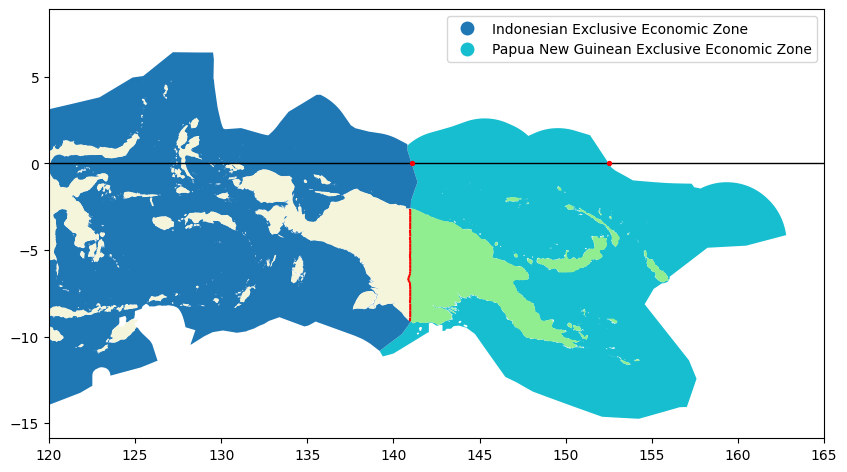

In [3]:
# Prepare intersections

papua_equator_intersection = papua_eez.exterior.intersection(equator).explode(index_parts=True)
indonesia_papua_boundary = gp.GeoDataFrame(geometry=indonesia_land.boundary.intersection(papua_land))
environment = pd.concat([papua_eez, indonesia_eez])

# Plot
ax = environment.plot(column="GEONAME", legend=True, figsize=(10, 10))
ax.set_xlim([120, 165])
gp.GeoSeries(papua_equator_intersection).plot(ax=ax, color="red", markersize=8, zorder=10)
gp.GeoSeries(equator).plot(lw=1, edgecolor="black", ax=ax)
indonesia_land.plot(ax=ax, color="beige")
papua_land.plot(ax=ax, color="lightgreen")
indonesia_papua_boundary.plot(ax=ax, color="red", markersize=8)

In [6]:
def to_cartesian(long):
    return 180 + (180 + long)

treaty_geo = shp.geometry.Polygon(
    [
        # 1. commencing at the point of intersection of the Equator by the maritime boundary between Indonesia and Papua New Guinea;
        # 2. running thence northerly along that maritime boundary to its intersection by the
        #    outer limit of the Exclusive Economic Zone of Papua New Guinea;
        # 3. thence generally north-easterly, easterly and south-easterly along that outer limit to its intersection by the Equator;
        *list(
            papua_eez.exterior.intersection(
                shp.geometry.box(130, 0, papua_equator_intersection.iloc[1].x, 5)
            )
            .explode(index_parts=True)
            .iloc[1]
            .coords
        ),
        *list(
            papua_eez.exterior.intersection(
                shp.geometry.box(130, 0, papua_equator_intersection.iloc[1].x, 5)
            )
            .explode(index_parts=True)
            .iloc[0]
            .coords
        ),
        # 4. thence east along the Equator to its intersection by the meridian of Longitude 163 degrees East;
        (163, 0),
        # 5. thence north along that meridian to its intersection by the parallel of Latitude 3 degrees North;
        (163, 3),
        # 6. thence east along that parallel to its intersection by the meridian of Longitude 171 degrees East;
        (171, 3),
        # 7. thence north along that meridian to its intersection by the parallel of Latitude 4 degrees North;
        (171, 4),
        # 8. thence east along that parallel to its intersection by the meridian of Longitude 180 degrees East;
        (180, 4),
        # 9. thence south along that meridian to its intersection by the Equator;
        (180, 0),
        # 10. thence east along the Equator to its intersection by the meridian of Longitude 165 degrees West;
        (to_cartesian(-165), 0),
        # 11. thence north along that meridian to its intersection by the parallel of Latitude 5 degrees 30 minutes North;
        (to_cartesian(-165), 5.5),
        # 12. thence east along that parallel to its intersection by the meridian of Longitude 154 degrees West;
        (to_cartesian(-154), 5.5),
        # 13. thence south along that meridian to its intersection by the Equator;
        (to_cartesian(-154), 0),
        # 14. thence east along the Equator to its intersection by the meridian of Longitude 115 degrees West;
        (to_cartesian(-115), 0),
        # 15. thence south along that meridian to its intersection by the parallel of Latitude 60 degrees South;
        (to_cartesian(-115), -60),
        # 16. thence west along that parallel to its intersection by the meridian of Longitude 115 degrees East;
        (115, -60),
        # 17. thence north along the meridian to its southernmost intersection by the outer limit of the territorial sea of Australia;
        (115, australia_12nm.intersection(long115).bounds.miny),
        # 18. thence generally northerly and easterly along the outer limit of the territorial sea of Australia
        # to its intersection by the meridian of Longitude 136 degrees 45 minutes East;
        *list(
            australia_12nm.boundary.intersection(
                shp.geometry.box(
                    110, australia_12nm.intersection(long115).bounds.miny, 136.75, 0
                )
            )
            .explode(index_parts=True)
            .iloc[3]
            .coords
        ),
        # 19. thence north-easterly along the geodesic to the point of Latitude 10 degrees 50 minutes South,
        # Longitude 139 degrees 12 minutes East;
        (139.2, -10.8333),
        # 20. thence north-easterly along the maritime boundary between Indonesia and Papua New Guinea to
        # where it joins the land border between those two countries;
        *list(
            papua_eez.boundary.intersection(
                shp.geometry.box(
                    139.2,
                    -10.8333,
                    indonesia_papua_boundary.bounds.minx,
                    indonesia_papua_boundary.bounds.miny,
                )
            )
            .explode(index_parts=True)
            .iloc[1]
            .coords
        ),
        # 21. thence generally northerly along the land border to where it joins the maritime boundary between
        # Indonesia and Papua New Guinea, on the northern coastline of Papua New Guinea; and
        (indonesia_papua_boundary.bounds.maxx, indonesia_papua_boundary.bounds.maxy),
        # 22. thence generally northerly along that boundary to the point of commencement.
        *list(
            papua_eez.boundary.intersection(
                shp.geometry.box(
                    indonesia_papua_boundary.bounds.maxx,
                    indonesia_papua_boundary.bounds.maxy,
                    papua_equator_intersection.iloc[1].x,
                    0,
                )
            )
            .explode(index_parts=True)
            .iloc[1]
            .coords
        ),
    ]
)

antimeridian = shp.geometry.LineString([(180, 90), (180, -90)])
split_geoms = shp.ops.split(treaty_geo, antimeridian).geoms

treaty_extent = gp.GeoDataFrame(
    data={
        "geometry": [
            split_geoms[0],
            *list(gp.GeoSeries(split_geoms[1]).translate(-360, 0)),
        ]
    },
    geometry="geometry",
    crs="EPSG:4326",
)

treaty_extent.to_file("./tmp/rarotonga-extent.geojson")

<Axes: >

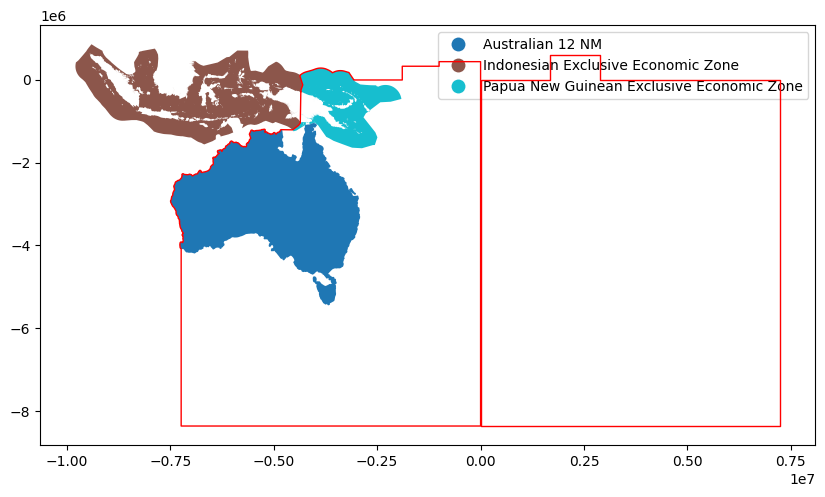

In [5]:
# Plot
proj4 = "+proj=merc +lon_0=180"
treaty_extent_proj = treaty_extent.to_crs(crs=proj4)
indonesia_eez_proj = indonesia_eez.to_crs(crs=proj4)
papua_eez_proj = papua_eez.to_crs(crs=proj4)
australia_12nm_proj = australia_12nm.to_crs(crs=proj4)

ax = pd.concat([papua_eez_proj, indonesia_eez_proj, australia_12nm_proj]).plot(
    column="GEONAME", legend=True, figsize=(10, 10)
)

treaty_extent_proj = treaty_extent.to_crs(crs=proj4)
treaty_extent_proj.plot(zorder=100, edgecolor="red", color="none", lw=1, ax=ax)